In [ ]:
%matplotlib inline


# SEGMENTATION AND GRAPH CUT


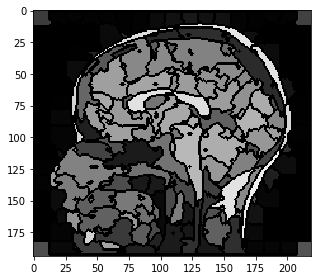

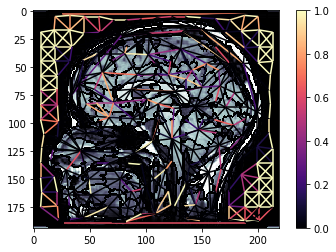

In [53]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from skimage.color import rgb2gray
from skimage.filters import sobel
import numpy as np
import matplotlib.pyplot as plt
import cv2

'''Input Image'''
img = io.imread("../images/brain_mri.jpg")
img=img[:,20:-20]

'''Super Pixel Segmentation method'''
#labels = segmentation.slic(img, compactness=10, n_segments=400)
#labels = segmentation.quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
labels = segmentation.watershed(gradient, markers=250, compactness=0.001)

'''Region Adjacency Graph'''
g = graph.rag_mean_color(img, labels, mode='similarity')

'''Output Image'''
img_out = color.label2rgb(labels, img, kind='avg')
img_out_bound = segmentation.mark_boundaries(img_out, labels, (0,0,0))

'''Display Image and RAG'''
io.imshow(img_out_bound)
io.show()
lg = graph.show_rag(labels, g, img)
plt.colorbar(lg)
plt.show()




[[  1   1   1 ...   1   1   1]
 [  1   1   1 ...   1   1   1]
 [  1   1   1 ...   1   1   1]
 ...
 [175 175 175 ... 175 175 175]
 [175 175 175 ... 175 175 175]
 [175 175 175 ... 175 175 175]]


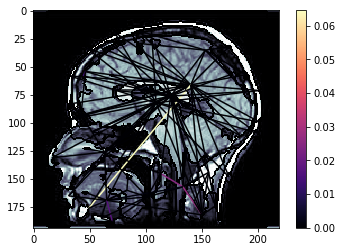

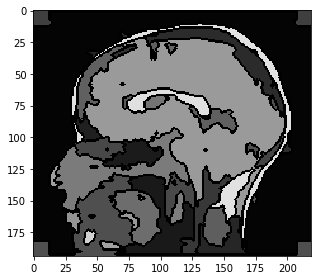

In [55]:
'''Normalized cut'''
new_labels = graph.cut_normalized(labels, g)
print(new_labels)

'''NEW RAG'''
new_g = graph.rag_mean_color(img, new_labels, mode='similarity')
lg = graph.show_rag(new_labels, new_g, img)
plt.colorbar(lg)
plt.show()

'''Image after Normalized Cut'''
img_out = color.label2rgb(new_labels, img, kind='avg')
img_out_bound = segmentation.mark_boundaries(img_out, new_labels, (0,0,0))
io.imshow(img_out_bound)
io.show()

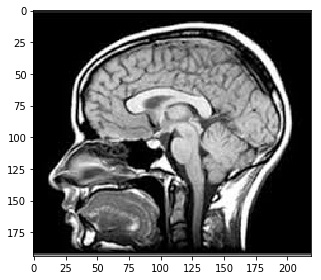

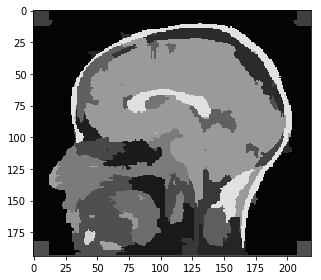

In [109]:
io.imshow(img)
io.show()
io.imshow(img_out)
io.show()

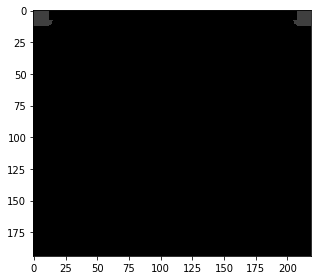

C:\Users\shyam\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


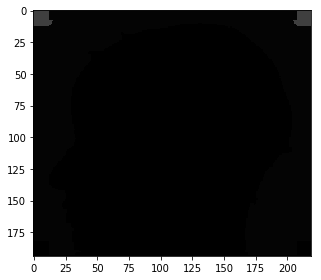

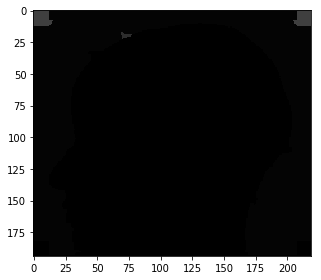

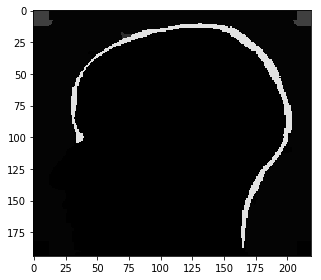

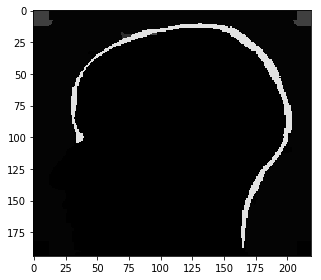

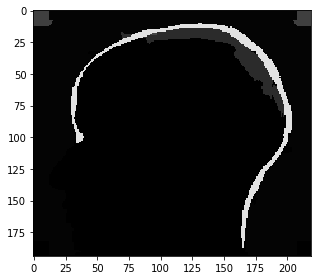

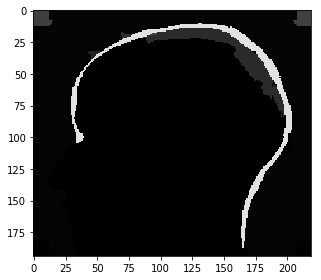

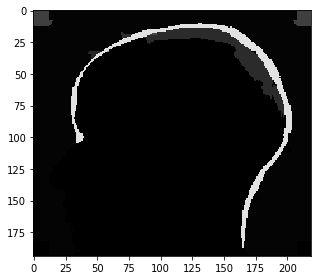

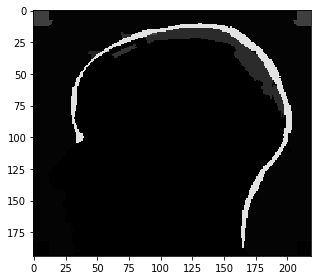

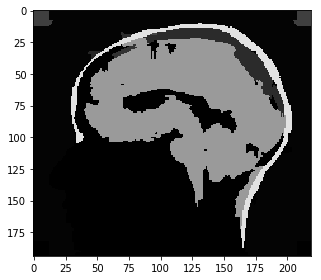

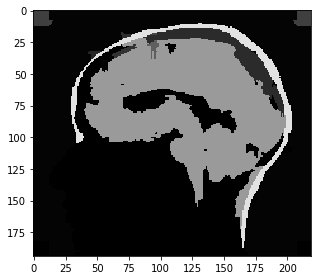

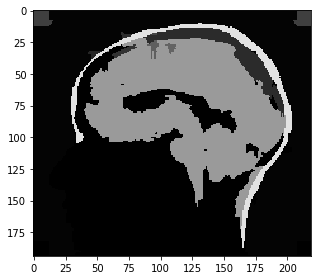

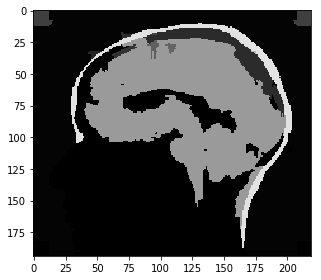

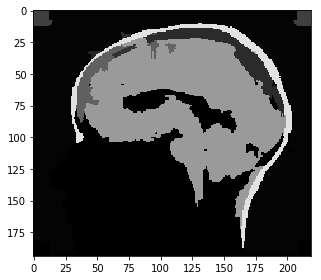

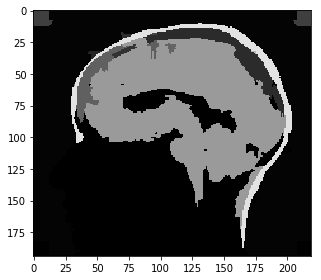

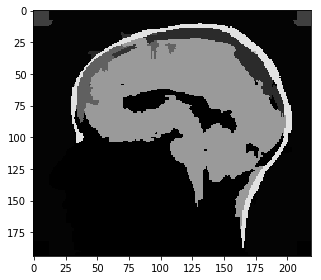

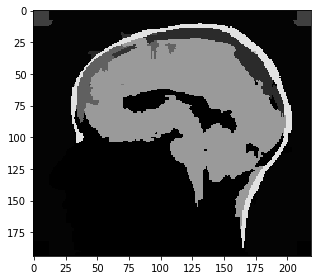

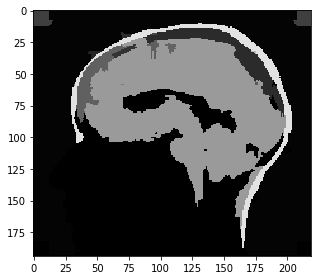

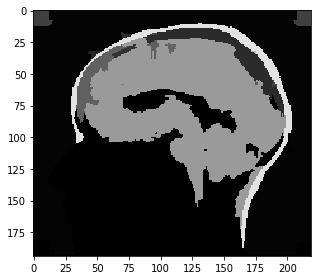

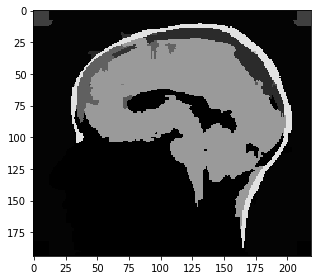

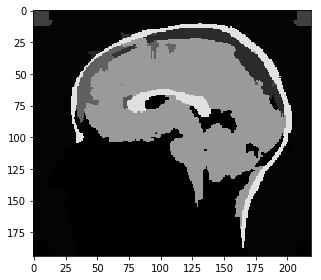

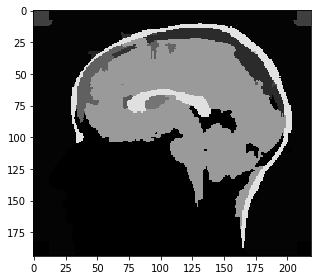

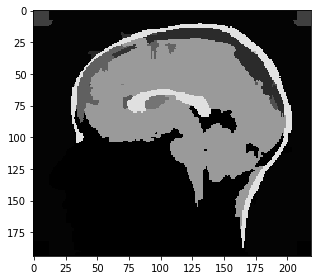

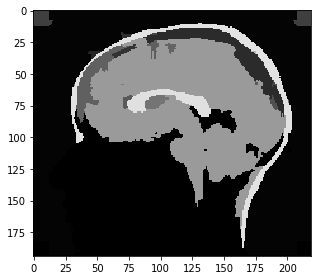

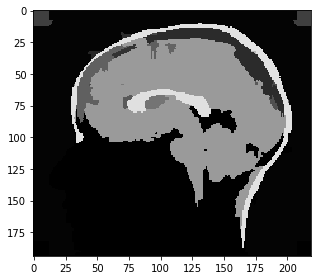

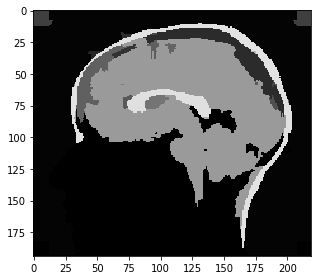

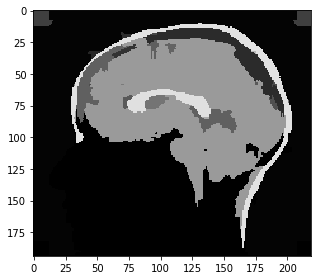

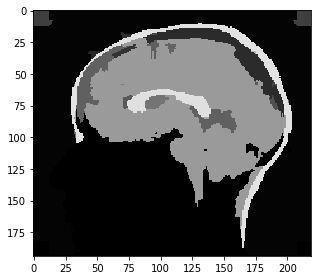

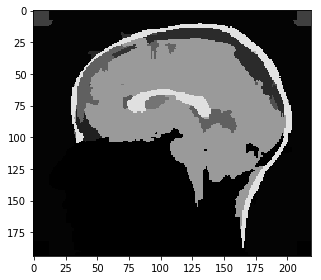

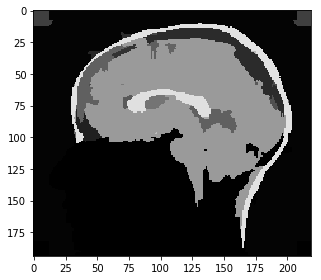

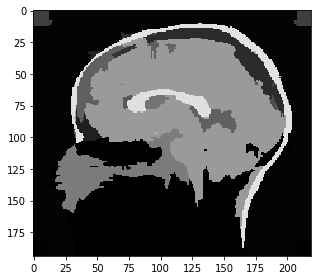

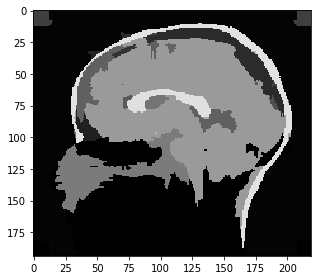

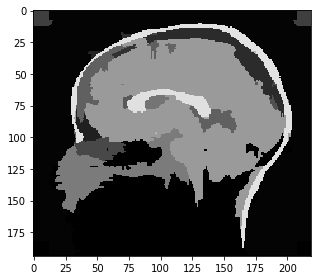

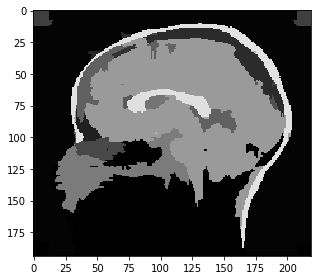

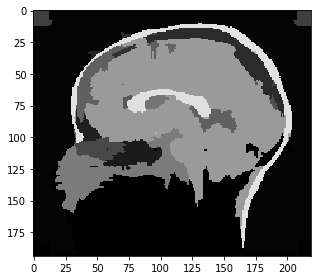

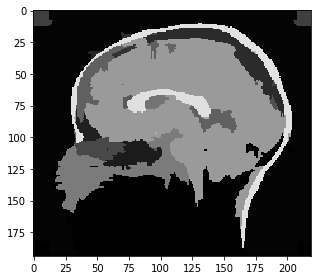

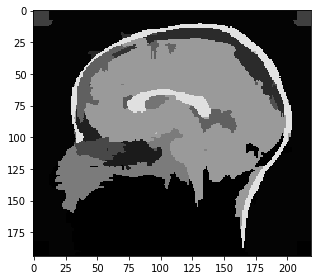

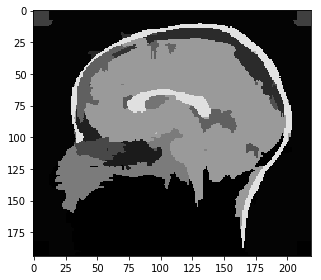

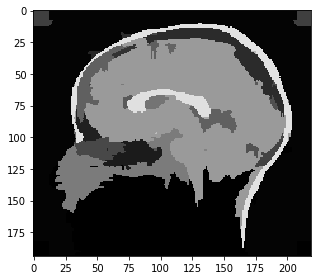

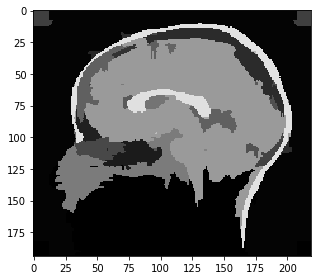

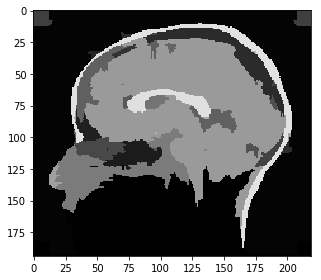

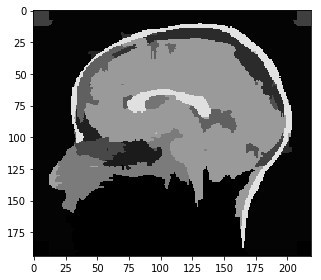

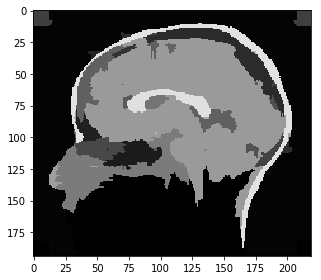

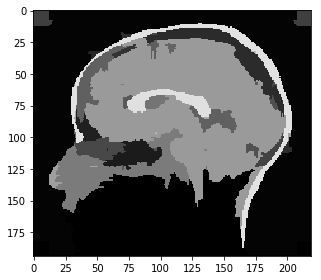

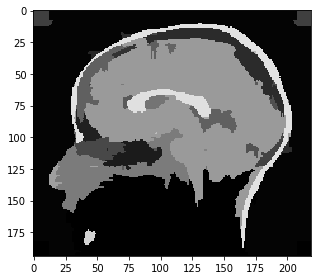

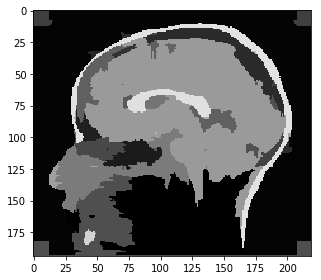

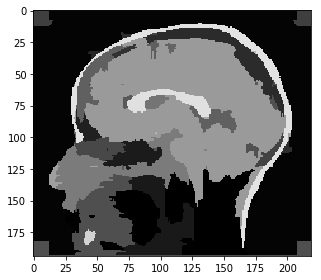

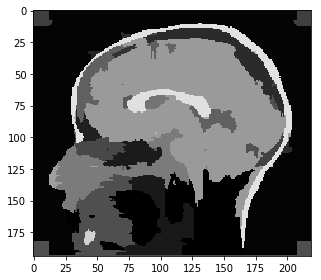

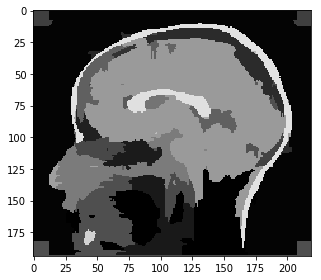

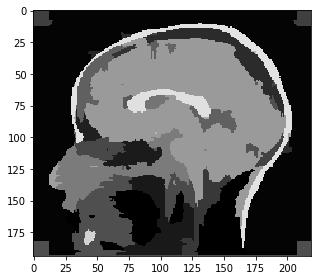

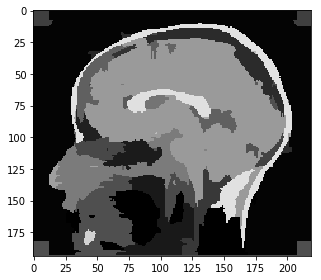

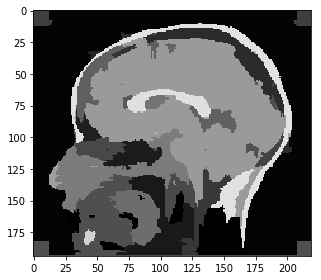

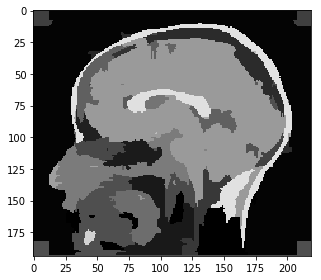

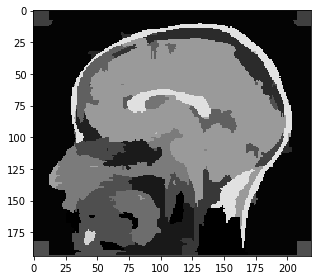

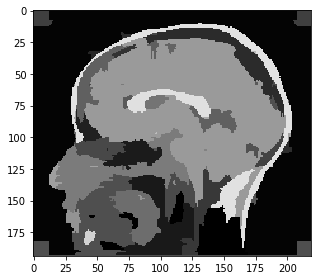

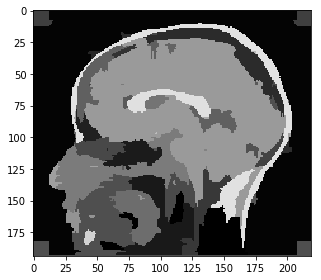

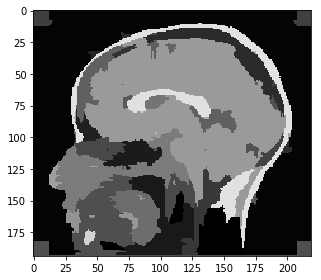

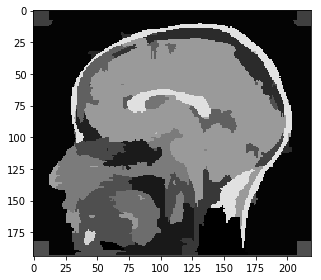

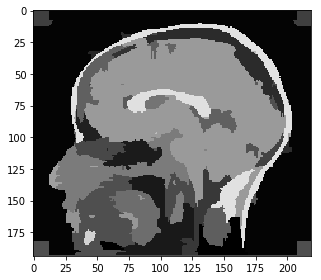

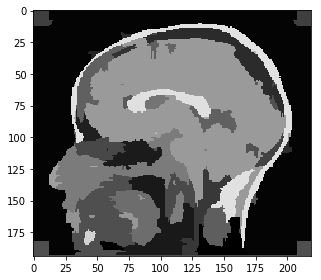

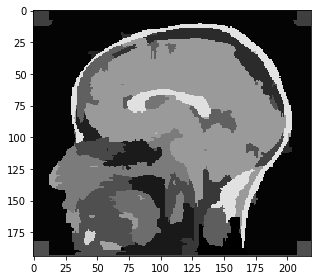

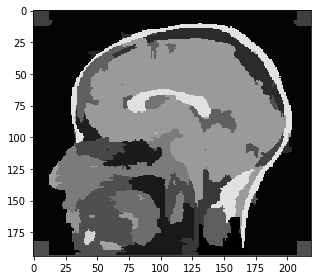

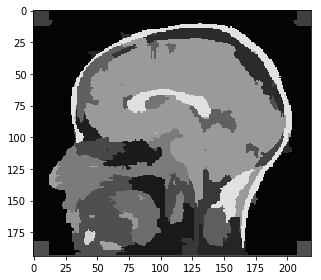

63


In [110]:
'''Parses through the new_labels array and creates masks to obtain all the superpixel segments separately and 
adds it progressively to obtain the image'''
def show_all_segments():
    final_img = []
    n = 0
    for i,seg in enumerate(np.unique(new_labels)):  
        mask = np.zeros(img_out.shape[:2], dtype="uint8")
        mask[new_labels == seg] = 255
        #io.imshow(mask)
        #io.show()
        i = cv2.bitwise_and(img_out, img_out, mask=mask)
        if(len(np.unique(i))) == 2: #and np.unique(i)[1] != 226:
            if final_img  == []:
                final_img = np.zeros(i.shape, dtype="uint8")
            final_img = cv2.add(final_img, i)
            #io.imshow(i)
            #io.show()
            n += 1
        io.imshow(final_img)
        io.show()
    #io.imshow(final_img)
    #io.show()
    print(n)
    
show_all_segments()


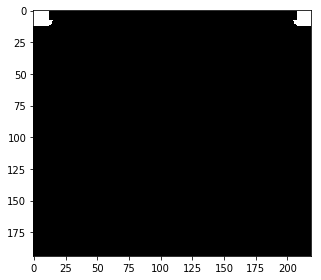

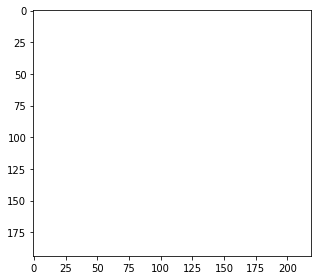

In [83]:
'''Mask Trials'''

mask = np.zeros(img_out.shape[:2], dtype="uint8")
mask[new_labels == 1] = 255
io.imshow(mask)
io.show()
i = cv2.bitwise_and(img_out, img_out, mask=mask)

#b_channel, g_channel, r_channel = cv2.split(i)
#alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 0
#i = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))

io.imshow(i)
#io.imshow(cv2.bitwise_and(img_out, img_out, mask=mask))
io.show()

In [ ]:
'''RAG and Hierarchical Merging'''

def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])

new_labels = graph.merge_hierarchical(labels, g, thresh=35, rag_copy=False, in_place_merge=True,
                                      merge_func=merge_mean_color, weight_func=weight_mean_color)
print(new_labels)
img_out = color.label2rgb(new_labels, img, kind='avg')
img_out = segmentation.mark_boundaries(img_out, new_labels, (0,0,0))
io.imshow(img)
io.show()
io.imshow(img_out)
io.show()